# NBSVM

In [1]:
%matplotlib inline

import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

## Standard imports for `ktrain`

In [2]:
import ktrain
from ktrain import text
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

## Build test and training sets & define preprocessing

In [3]:
NUM_WORDS = 50000
MAXLEN = 8000
NGRAM_RANGE = 1

In [4]:
train, test, preproc = text.texts_from_csv('../data/train_80_10_10.csv',
                                          'cleaned_contents',
                                          label_columns=['Discrimination_Label'],
                                          val_filepath='../data/val_80_10_10.csv',
                                          max_features=NUM_WORDS,
                                          maxlen=MAXLEN,
                                          ngram_range=NGRAM_RANGE)

detected encoding: utf-8 (if wrong, set manually)
language: en
Word Counts: 17531
Nrows: 647
647 train sequences
train sequence lengths:
	mean : 1501
	95percentile : 3939
	99percentile : 7668
x_train shape: (647,8000)
y_train shape: (647, 2)
Is Multi-Label? False
81 test sequences
test sequence lengths:
	mean : 1510
	95percentile : 4141
	99percentile : 5507
x_test shape: (81,8000)
y_test shape: (81, 2)


## Define and train the model

In [5]:
model = text.text_classifier('nbsvm', train, preproc=preproc)
learner = ktrain.get_learner(model, train_data=train, val_data=test)

Is Multi-Label? False
compiling word ID features...
maxlen is 8000
building document-term matrix... this may take a few moments...
rows: 1-647
computing log-count ratios...
done.


In [6]:
learner.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 8000, 2)      35064       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 8000, 1)      17532       input_1[0][0]                    
__________________________________________________________________________________________________
dot (Dot)                       (None, 2, 1)         0           embedding[0][0]                  
                                                                 embedding_1[0][0]            

### Find a good initial learning rate

This is a method that was developed at the Naval Research Laboratory.  It's been promoted by Jeremy Howard.

simulating training for different learning rates... this may take a few moments...
Train on 647 samples
Epoch 1/5


/usr/local/lib/python3.6/dist-packages/ktrain/core.py:476: UserWarning: max_epochs is being set to 5 since steps per epoch is small. If you wish to estimate LR using more epochs, set max_epochs manually.
  'If you wish to estimate LR using more epochs, set max_epochs manually.')


647/647 [==============================] - 1s 1ms/sample - loss: 0.8620 - accuracy: 0.6121
Epoch 2/5
647/647 [==============================] - 0s 506us/sample - loss: 0.8262 - accuracy: 0.6151
Epoch 3/5
647/647 [==============================] - 0s 485us/sample - loss: 0.6357 - accuracy: 0.6461
Epoch 4/5
647/647 [==============================] - 0s 457us/sample - loss: 0.4190 - accuracy: 0.8733
Epoch 5/5
416/647 [==================>...........] - ETA: 0s - loss: 5.5935 - accuracy: 0.8462

done.
Visually inspect loss plot and select learning rate associated with falling loss


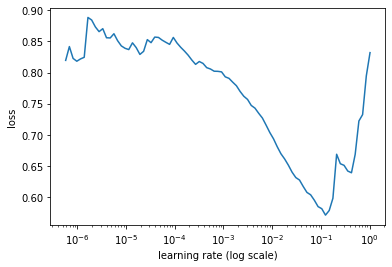

In [7]:
learner.lr_find(show_plot=True)

### Train

In [8]:
learner.autofit(1e-3, early_stopping=5)

reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train on 647 samples, validate on 81 samples
Epoch 1/1024
647/647 [==============================] - 1s 1ms/sample - loss: 0.6765 - accuracy: 0.6414 - val_loss: 0.6353 - val_accuracy: 0.6543
Epoch 2/1024
647/647 [==============================] - 0s 520us/sample - loss: 0.4936 - accuracy: 0.7697 - val_loss: 0.6586 - val_accuracy: 0.6790
Epoch 3/1024
544/647 [========================>.....] - ETA: 0s - loss: 0.4153 - accuracy: 0.8290
Epoch 00003: Reducing Max LR on Plateau: new max lr will be 0.0005 (if not early_stopping).
647/647 [==============================] - 0s 488us/sample - loss: 0.4119 - accuracy: 0.8346 - val_loss: 0.6698 - val_accuracy: 0.6790
Epoch 4/1024
647/647 [==============================] - 0s 484us/sample - loss: 0.3556 - accuracy: 0.8810 - val_loss: 0.6448 - val_accuracy: 0.6420
Epoch 5/1024
544/647 [========================>.....] -

## Examine results on the validation set

In [9]:
learner.validate(class_names=preproc.get_classes())

              precision    recall  f1-score   support

           0       0.63      0.36      0.46        33
           1       0.66      0.85      0.75        48

    accuracy                           0.65        81
   macro avg       0.65      0.61      0.60        81
weighted avg       0.65      0.65      0.63        81



array([[12, 21],
       [ 7, 41]])

# Evaluate on the test set

In [10]:
test = pd.read_csv('../data/test_80_10_10.csv')

In [11]:
x_test = list(test.cleaned_contents)
y_test = np.array(test.Discrimination_Label, dtype='int64')

In [12]:
predictor = ktrain.get_predictor(learner.model, preproc=preproc)

In [13]:
y_hat = np.array(predictor.predict(x_test), dtype='int64')
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.93      0.38      0.54        37
           1       0.65      0.98      0.78        44

    accuracy                           0.70        81
   macro avg       0.79      0.68      0.66        81
weighted avg       0.78      0.70      0.67        81



## Explain a prediction

In [14]:
predictor.explain('As the accused is the sole breadwinner for his family, I reduce his sentence by two years.')

## Run five experiments - retain results and save the best model based on performance on the validation set

In [16]:
results = {'acc': [], 'precision': [], 'recall': [], 'F1': []}
max_acc = 0

for i in range(5):
    learner.reset_weights()
    learner.autofit(1e-3, early_stopping=5)
    
    # Validation set - use this to pick the "best" model to avoid cheating
    val_results = learner.validate(class_names=preproc.get_classes())
    accv = val_results.diagonal().sum() / val_results.sum()
    if accv > max_acc:
        predictor.save('models/nbsvm')
    
    predictor = ktrain.get_predictor(learner.model, preproc=preproc)
    y_hat = np.array(predictor.predict(x_test), dtype='int64')
    cm = confusion_matrix(y_test, y_hat)
    # Test set
    TP = cm[1,1]
    TN = cm[0,0]
    FP = cm[1,0]
    FN = cm[0,1]
    acc = (TP + TN) / (TP + TN + FP + FN)
    results['acc'].append(acc)
    results['precision'].append(TP / (TP + FP))
    results['recall'].append(TP / (TP + FN))
    results['F1'].append(2 * TP / (2 * TP + FP + FN))

Model weights have been reset.
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train on 647 samples, validate on 81 samples
Epoch 1/1024
647/647 [==============================] - 0s 491us/sample - loss: 0.7341 - accuracy: 0.5997 - val_loss: 0.6352 - val_accuracy: 0.6420
Epoch 2/1024
647/647 [==============================] - 0s 485us/sample - loss: 0.5128 - accuracy: 0.7512 - val_loss: 0.6396 - val_accuracy: 0.6667
Epoch 3/1024
544/647 [========================>.....] - ETA: 0s - loss: 0.3995 - accuracy: 0.8419
Epoch 00003: Reducing Max LR on Plateau: new max lr will be 0.0005 (if not early_stopping).
647/647 [==============================] - 0s 508us/sample - loss: 0.4037 - accuracy: 0.8470 - val_loss: 0.7572 - val_accuracy: 0.7037
Epoch 4/1024
647/647 [==============================] - 0s 495us/sample - loss: 0.3349 - accuracy: 0.9088 - val_loss: 0.6203 - val_accuracy: 0.6667
Epoch 5/1024
647/647 [

## Compute averages

In [23]:
[print(metric + ' ' + str(np.array(results[metric]).mean())) for metric in ['acc', 'precision', 'recall', 'F1']]

acc 0.6987654320987654
precision 0.9045454545454545
recall 0.6649280622846472
F1 0.76549136433685


[None, None, None, None]

## Load the best model

In [24]:
best_predictor = ktrain.load_predictor('models/nbsvm')

In [25]:
best_predictor.explain('As the accused is the sole breadwinner for his family, I reduce his sentence by two years')